# Natural language processing of sentiment analysis from tweets

## Project Goal

Build, Train, Test and deploy a Naive Bayes Model to analyses 1000s of tweets as Positive or Neutral (0) or Negative (1) which lets companies understand customer feedback better and optimize on shortcomings

In [1]:
# import necessary packages 


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import the dataset

df = pd.read_csv('./twitter.csv')

In [3]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df.shape

(31962, 3)

In [5]:
df = df.drop(['id'], axis = 1)

## Exploratory Data Analysis (EDA)

In [6]:
# clean data and remove duplicates

df.isna().sum()

label    0
tweet    0
dtype: int64

In [7]:
df.duplicated().sum()

2432

In [8]:
df = df.drop_duplicates(keep='first').copy()

In [9]:
df.shape

(29530, 2)

In [10]:
df.duplicated().sum()

0

In [11]:
df.describe(include='all')

,label,tweet
count,29530.000000,29530
unique,NaN,29530
top,NaN,@user when a father is dysfunctional and is s...
freq,NaN,1
mean,0.068168,NaN
std,0.252038,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN


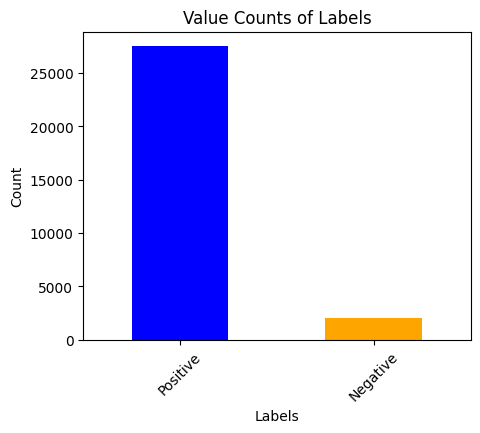

In [12]:
plt.figure(figsize=(5,4))
ax = df['label'].value_counts().plot(kind='bar', color=['blue','orange'])

# Adding custom tick labels
ax.set_xticklabels(['Positive', 'Negative'], rotation = 45)

# Adding title and labels
plt.title('Value Counts of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

# Display the plot
plt.show()

In [13]:
df['label'].value_counts(normalize = True)*100

label
0    93.183204
1     6.816796
Name: proportion, dtype: float64

A vast majority of tweets nearly 93% are either positive or neutral and only a small number around 7% are labeled as negative tweets

In [14]:
# Feature engineering to add tweet length as a new column

df['tweet_length'] = df['tweet'].str.len()

df.head()

,label,tweet,tweet_length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


In [15]:
df.groupby('label')['tweet_length'].agg(['count', 'mean', 'median'])


,count,mean,median
label,,,
0,27517,84.810590,89.0
1,2013,91.416791,98.0


On average the negative tweets are longer by around 8 characters as compared to the positive ones and the same trend is observable in the median too. This might be because people describe the reason for their negative experiences

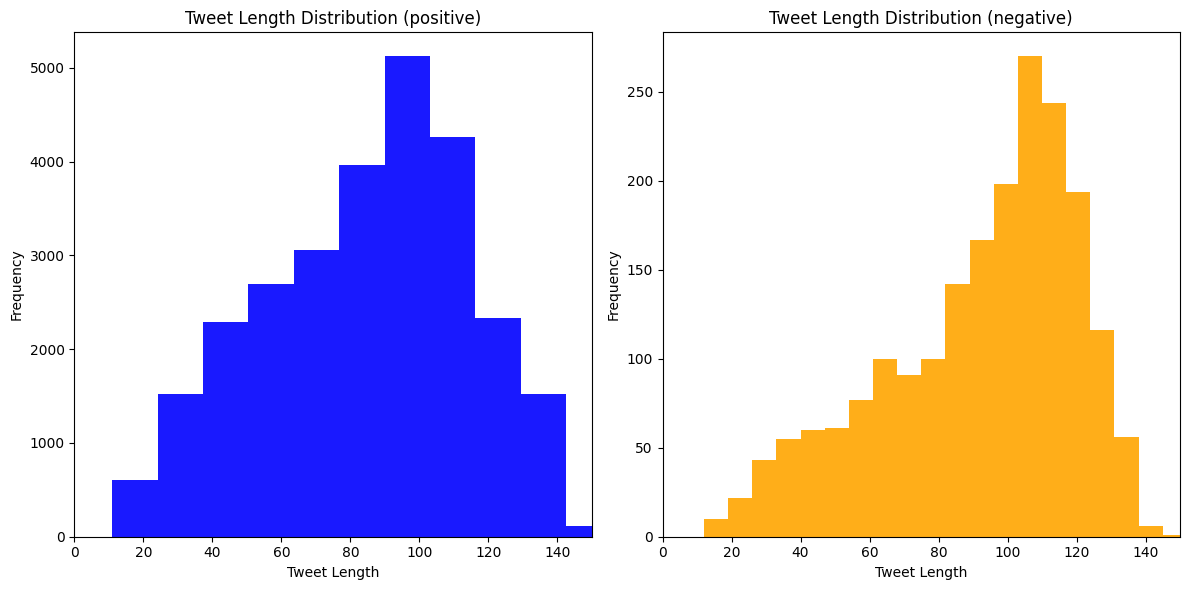

In [16]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row, 2 columns

# Plot histogram for label 0
axes[0].hist(df[df['label'] == 0]['tweet_length'], bins=20, alpha=0.9, color='blue')
axes[0].set_title('Tweet Length Distribution (positive)')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(0,150)
# Plot histogram for label 1
axes[1].hist(df[df['label'] == 1]['tweet_length'], bins=20, alpha=0.9, color='orange')
axes[1].set_title('Tweet Length Distribution (negative)')
axes[1].set_xlabel('Tweet Length')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0,150)
# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

The distribution of tweet lengths for both sentiments look similar with a vast majority of tweets having between 80 and 110 characters

In [17]:
df[df['label'] == 0]['tweet_length'].describe()

count    27517.000000
mean        84.810590
std         29.976615
min         11.000000
25%         62.000000
50%         89.000000
75%        108.000000
max        274.000000
Name: tweet_length, dtype: float64

In [18]:
df[df['label'] == 1]['tweet_length'].describe()

count    2013.000000
mean       91.416791
std        27.989697
min        12.000000
25%        74.000000
50%        98.000000
75%       112.000000
max       152.000000
Name: tweet_length, dtype: float64

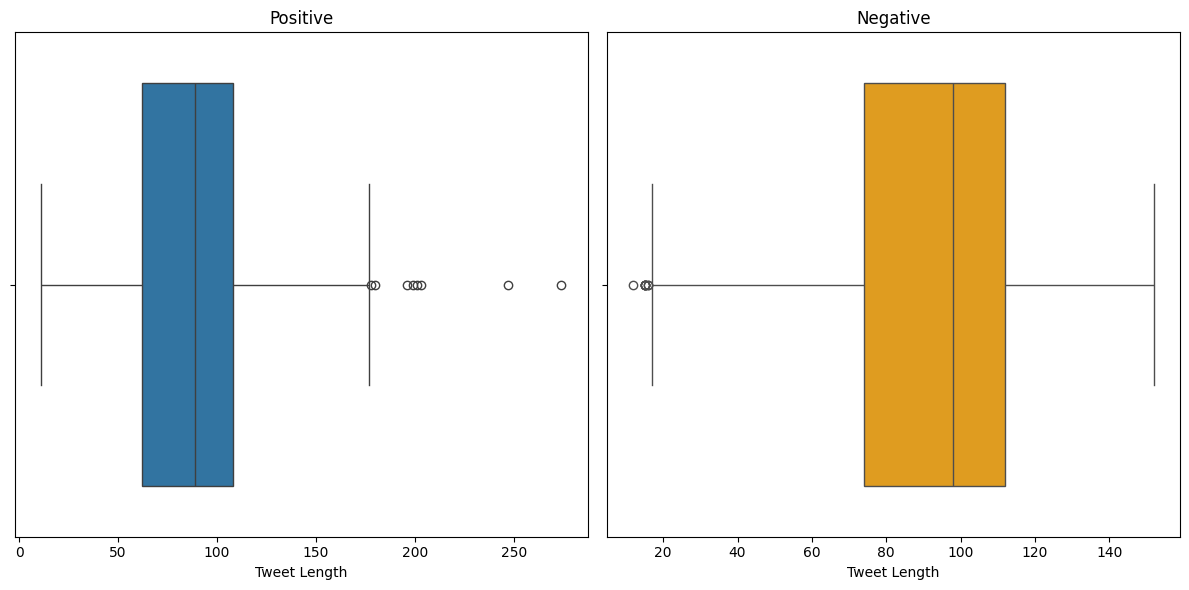

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# Create boxplot for label 0
sns.boxplot(x='tweet_length', data=df[df['label'] == 0], ax=axes[0])
axes[0].set_title('Positive')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('')

# Create boxplot for label 1
sns.boxplot(x='tweet_length', data=df[df['label'] == 1], ax=axes[1], color='orange')
axes[1].set_title('Negative')
axes[1].set_xlabel('Tweet Length')
axes[1].set_ylabel('')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## Data cleaning and removing punctuations and @user hyperlinks

In [20]:
import string


In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
# define a function to remove all punctuations and return clean text

def remove_punc(text):

    clean_text = "".join(char for char in text if char not in string.punctuation)
    return clean_text.strip()

In [23]:
clean_test = remove_punc(" !! america & >")
clean_test

'america'

In [24]:
# Remove the word "user" from the sentence

def remove_user(text):

    text_no_user = text.lower().replace('user','')
    return text_no_user.strip()



In [25]:
user_test = remove_user('@USer and user are irritation usER')
user_test

'@ and  are irritation'

## Remove stop words as they add no further value

In [26]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nihal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
stopwords_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [28]:
# remove all stopwords 

def remove_stopwords(text):
    text_lower = text.lower()
    text_no_sw = [word for word in text_lower.split() if word not in stopwords_list]
    return " ".join(text_no_sw)

    

In [29]:
sw_test = remove_stopwords('Me and user friends and their girlfriends were at some random party')
sw_test

'user friends girlfriends random party'

In [30]:
# lets combine all functions defined above
import re

def clean_text(text):
    no_sw = remove_stopwords(text)
    no_user = remove_user(no_sw)
    no_punc = remove_punc(no_user)

    clean = re.sub(' +',' ',no_punc)
    clean = re.sub(r'[^a-zA-Z\s]', '', clean)
    return clean   

In [31]:
clean_test = clean_text("@User is not a good friend & is a di*khead!!")
clean_test

'good friend dikhead'

In [32]:
df['clean_tweet'] = df['tweet'].apply(clean_text)

df.head()

,label,tweet,tweet_length,clean_tweet
0,0,@user when a father is dysfunctional and is s...,102,father dysfunctional selfish drags kids dysfun...
1,0,@user @user thanks for #lyft credit i can't us...,122,thanks lyft credit cant use cause offer wheelc...
2,0,bihday your majesty,21,bihday majesty
3,0,#model i love u take with u all the time in ...,86,model love u take u time ur
4,0,factsguide: society now #motivation,39,factsguide society motivation


## Plotting the word cloud


In [33]:
pos_df = df[df['label'] == 0].copy()
neg_df = df[df['label'] == 1].copy()

In [34]:
pos_sentences = pos_df['clean_tweet'].tolist()
pos_sentences = (" ").join(pos_sentences)


In [35]:
neg_sentences = neg_df['clean_tweet'].tolist()
neg_sentences = (" ").join(neg_sentences)


In [36]:
from wordcloud import WordCloud

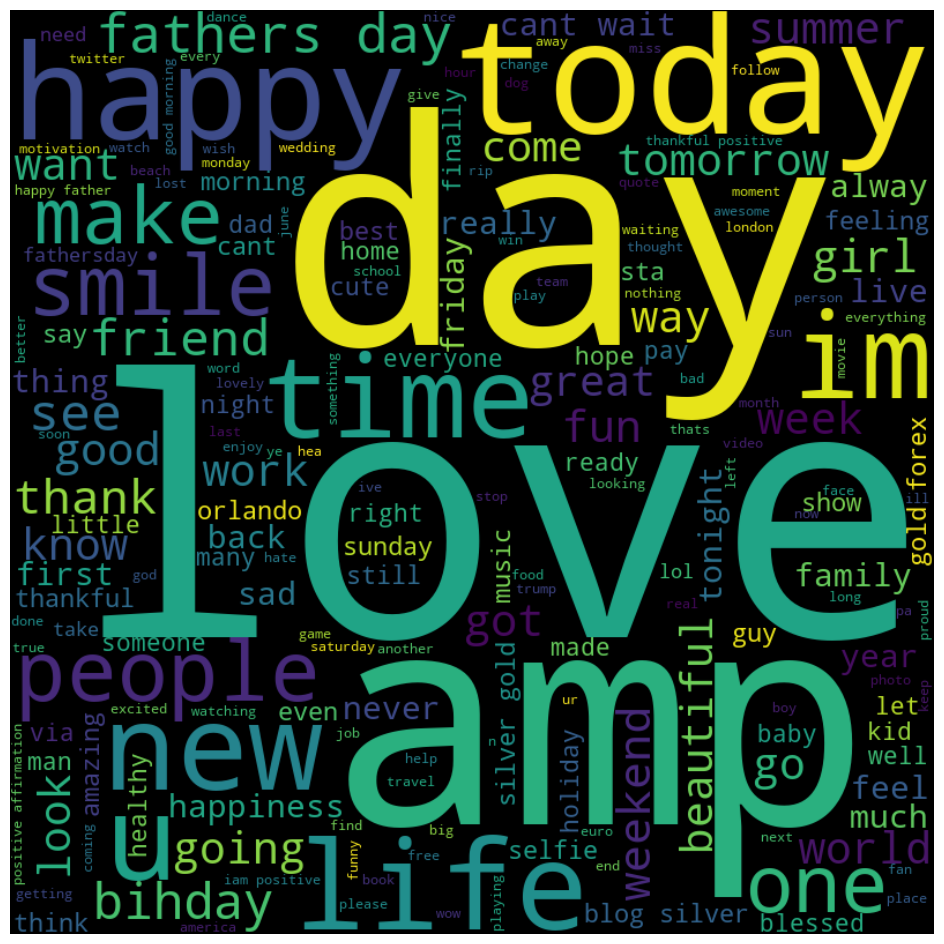

<Figure size 640x480 with 0 Axes>

In [59]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='black').generate(pos_sentences)

# Plot the word cloud
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('word_cloud.pdf')

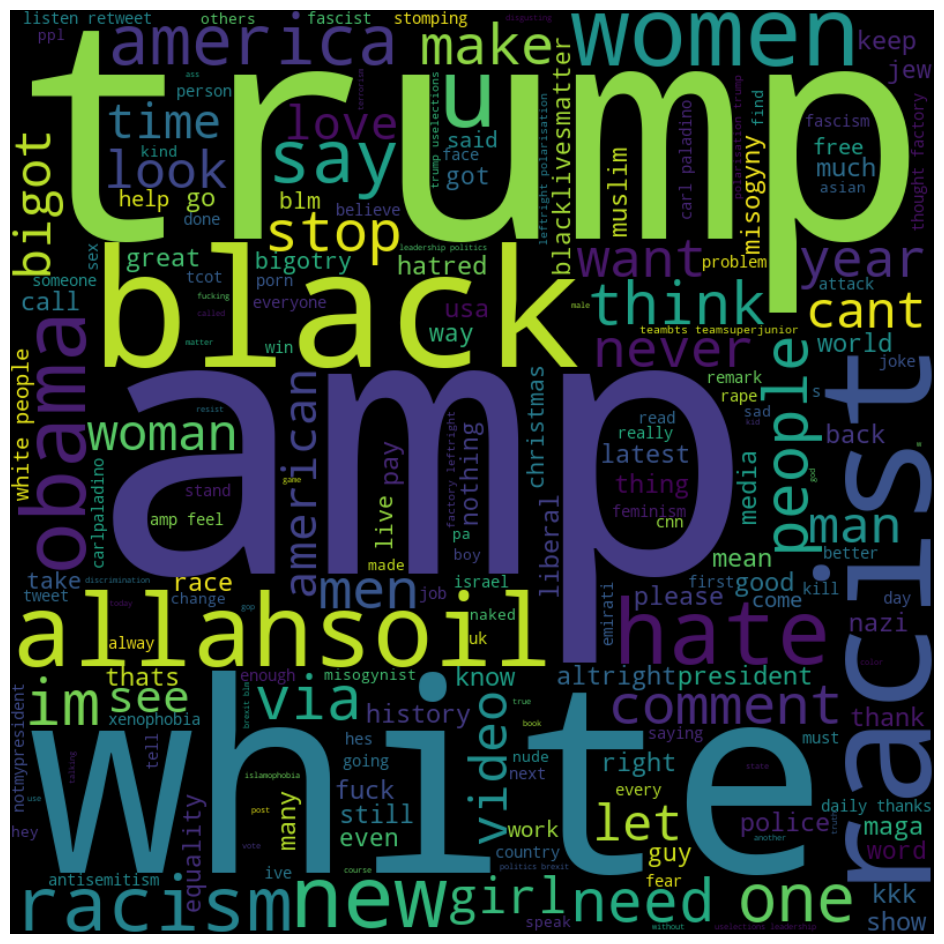

In [38]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='black').generate(neg_sentences)

# Plot the word cloud
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Tokenization

Convert text into string of numbers dependent on how frequent unique words appear in the text

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
vectorizer = CountVectorizer(dtype=  np.uint8)
tweet_cv = vectorizer.fit_transform(df['clean_tweet'])

In [43]:
print(tweet_cv.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [47]:
tweet_cv.shape

(29530, 39693)

## Define features and target variable and do a test-train split to train Naive Bayes

P(y|X) = P(X|y)*P(y)/P(X)

In [45]:
X = pd.DataFrame(tweet_cv.toarray())

In [46]:
y = df['label']

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [51]:
NB_clf = MultinomialNB()
NB_clf.fit(X_train, y_train)

MultinomialNB()

In [52]:
y_pred = NB_clf.predict(X_test)

## Evaluate the results

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8247
           1       0.58      0.47      0.52       612

    accuracy                           0.94      8859
   macro avg       0.77      0.72      0.74      8859
weighted avg       0.93      0.94      0.94      8859



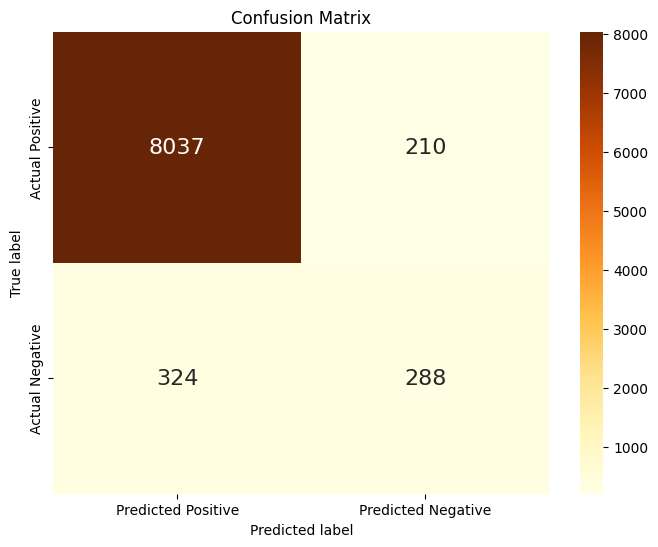

<Figure size 640x480 with 0 Axes>

In [60]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to DataFrame for easier manipulation
conf_df = pd.DataFrame(conf_matrix, index=['Actual Positive', 'Actual Negative'], columns=['Predicted Positive', 'Predicted Negative'])

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, cmap='YlOrBr', fmt='d', annot_kws={'size': 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
plt.savefig('cm_tweets.pdf')

## Final Report

1. We wish to predict if a tweet conveys a negative sentiment (1) or a positive sentiment (0)
2. The data set is heavily imbalanced with 93% of the data labeled 0 and 7% labeled 1
3. We used Naive Bayes after EDA and tokenization
4. We are interested in class 1 and find that the precision is around 0.58 and recall around 0.47 which is apparent from the confusion matrix above TP = 288, FP = 210, FN = 324
5. The scores are **pretty poor and Naive Bayes does not do a very good job** at tweet classification
6. Negative tweets affect public sentiment a lot more and might need to be moderated by human reviewers if they contain obscene or hate spreading ideologies. But a lot of negative tweets are flagged as positive which might be a cause of concern. 